In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import data_utils

import importlib
importlib.reload(data_utils)

RUN_FOLDER = "../results/medium/"
RUN_FOLDER_TTE = "../results/small/"

In [13]:
# # Do Not Include DeepTTE Results:
# kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
# atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
# kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
# atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)

# performances_df = pd.concat([kcm_result_df, atb_result_df], axis=0).sort_values(['Model','City','Fold'])
# model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

# print(f"All Unique Models: {pd.unique(performances_df['Model'])}")
# print(f"All NN Models: {pd.unique(model_curves_df['Model'])}")

In [16]:
# Include DeepTTE Results:
kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)

kcm_deeptte_results = data_utils.extract_deeptte_results("Seattle", RUN_FOLDER_TTE, "kcm/")
atb_deeptte_results = data_utils.extract_deeptte_results("Trondheim", RUN_FOLDER_TTE, "atb/")
kcm_deeptte_result_df = kcm_deeptte_results[['Model','City','Fold','MAPE','RMSE','MAE']].copy()
atb_deeptte_result_df = atb_deeptte_results[['Model','City','Fold','MAPE','RMSE','MAE']].copy()

performances_df = pd.concat([kcm_result_df, atb_result_df, kcm_deeptte_result_df, atb_deeptte_result_df], axis=0).sort_values(['Model','City','Fold'])
model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

print(f"All Unique Models: {pd.unique(performances_df['Model'])}")
print(f"All NN Models: {pd.unique(model_curves_df['Model'])}")

All Unique Models: ['AVG' 'CONV1D' 'DeepTTE' 'FF' 'GRU_RNN' 'GRU_RNN_MTO' 'PER_TIM' 'SCH'
 'TRSF_ENC']
All NN Models: ['FF' 'GRU_RNN' 'GRU_RNN_MTO' 'CONV1D' 'TRSF_ENC']


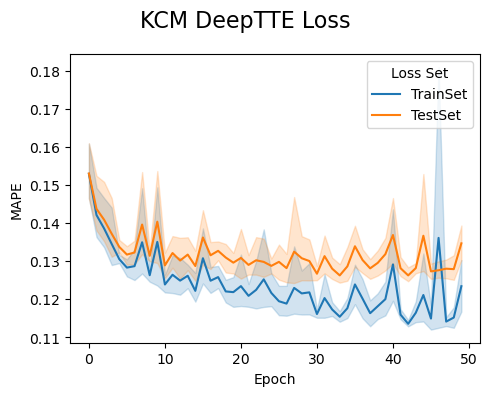

In [17]:
# DeepTTE KCM curves
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(kcm_deeptte_results, x="Epoch", y="MAPE", hue="Loss Set", hue_order=["TrainSet","TestSet"], ax=axes)
fig.suptitle('KCM DeepTTE Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_deeptte_kcm.png", dpi=1800, bbox_inches='tight')

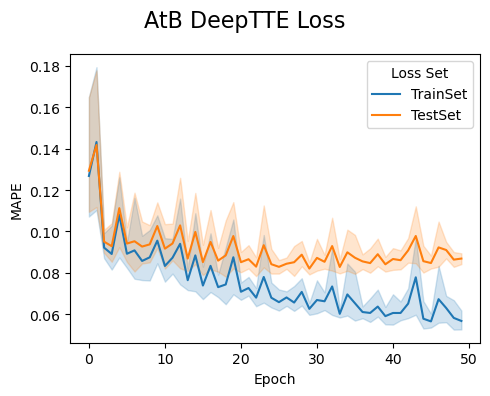

In [18]:
# DeepTTE AtB curves
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(atb_deeptte_results, x="Epoch", y="MAPE", hue="Loss Set", hue_order=["TrainSet","TestSet"], ax=axes)
fig.suptitle('AtB DeepTTE Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_deeptte_atb.png", dpi=1800, bbox_inches='tight')

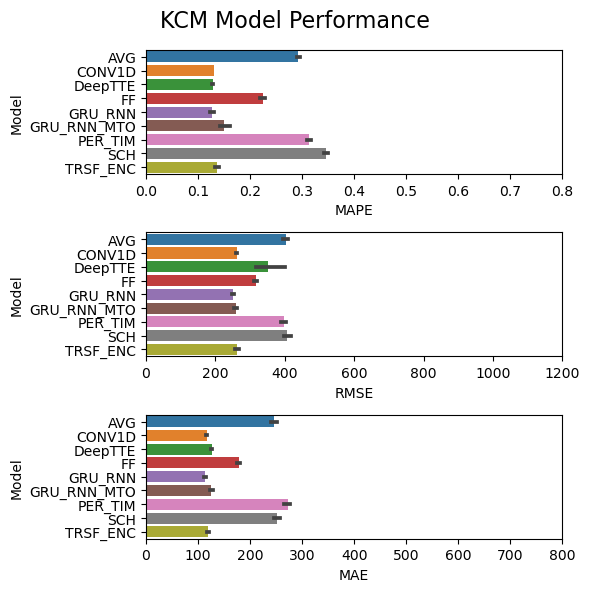

In [19]:
plot_data = performances_df[performances_df['City']=="Seattle"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
axes[0].set_xlim([0, 0.8])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
axes[1].set_xlim([0, 1200])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
axes[2].set_xlim([0, 800])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.png", dpi=1800, bbox_inches='tight')

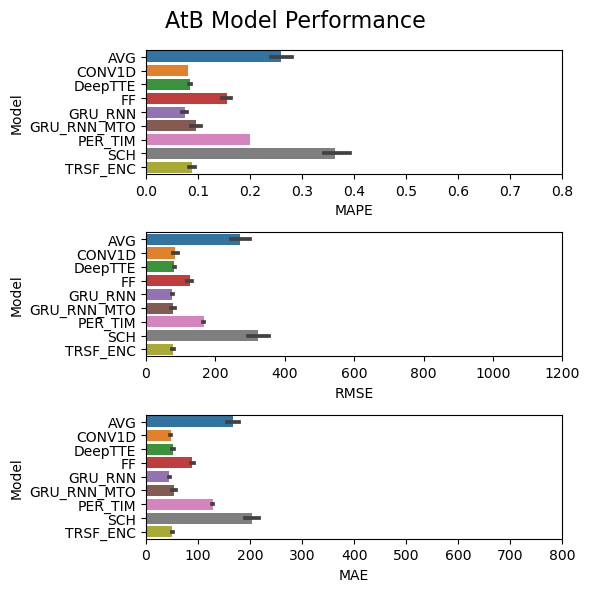

In [20]:
plot_data = performances_df[performances_df['City']=="Trondheim"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
axes[0].set_xlim([0, 0.8])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
axes[1].set_xlim([0, 1200])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
axes[2].set_xlim([0, 800])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.png", dpi=1800, bbox_inches='tight')

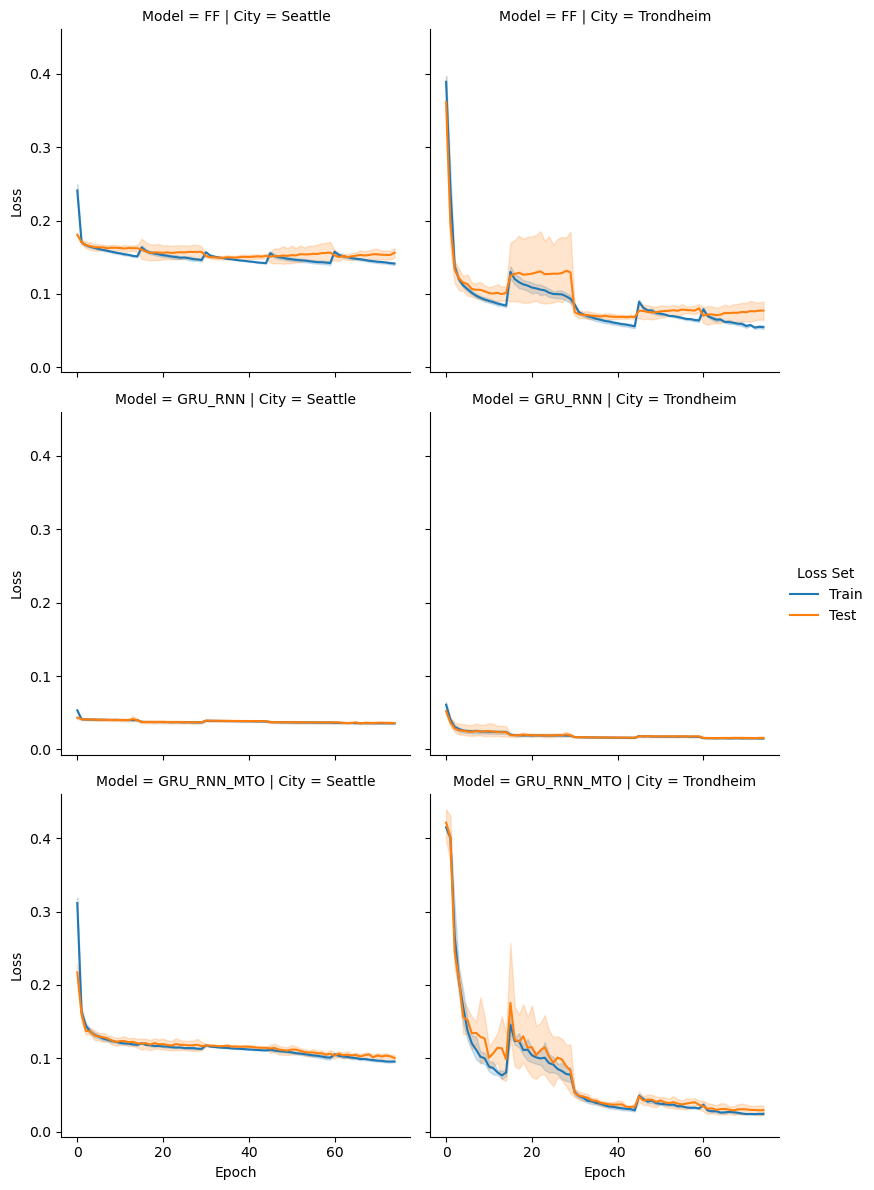

In [21]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[:3])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Test"], height=4)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_1.png", dpi=1800, bbox_inches='tight')

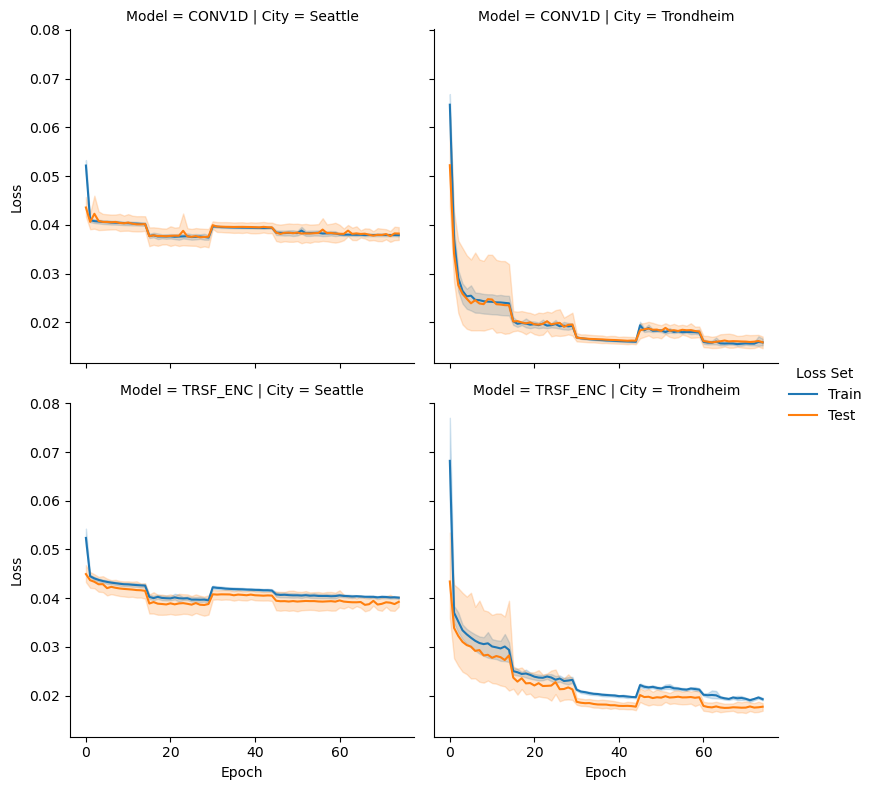

In [22]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[3:])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Test"], height=4)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_2.png", dpi=1800, bbox_inches='tight')